In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import os

In [2]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'HDD_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

#np.random.seed(123)
#merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

# Train / Test

In [3]:
train_test_split_original_data_path = "../data/03_processed/train_test_split_original_data.csv"
train_test_split_original_data = pd.read_csv(train_test_split_original_data_path)

train_test_split_new_data_path = "../data/03_processed/train_test_split_new_data.csv"
train_test_split_new_data = pd.read_csv(train_test_split_new_data_path)

train_test_split = pd.concat([train_test_split_original_data, train_test_split_new_data], ignore_index=True)

merged_df = merged_df.merge(train_test_split, on=['index', 'geonameid'], how='left')

# We want to keep original data 
merged_df = merged_df[merged_df["source"] == "World Bank CURB"]

merged_df = merged_df.dropna(subset=['pca_result']) # we delete 9 points without image

train_df = merged_df[merged_df['is_train'] == 1].copy()


In [4]:
merged_df

,index,geonameid,name_x,asciiname,latitude,longitude,iso alpha 2,City,Geonames ID,Country,...,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Predicted_Cluster,GDP_per_capita,is_train
0,0,292968,Abu Dhabi,Abu Dhabi,24.45118,54.39696,AE,Abu Dhabi,292968,United Arab Emirates,...,0.049996,0.050059,0.049936,0.050036,0.050129,0.049987,0.050072,17.0,9.845673e-08,1
1,1,1138958,Kabul,Kabul,34.52813,69.17233,AF,Kabul,1138958,Afghanistan,...,0.049996,0.050078,0.049910,0.050046,0.050170,0.049979,0.050096,17.0,1.093754e-08,1
2,2,3183875,Tirana,Tirana,41.32750,19.81889,AL,Tirana,3183875,Albania,...,0.049993,0.050093,0.049902,0.050044,0.050187,0.049984,0.050108,17.0,2.873300e-07,1
3,3,616052,Yerevan,Yerevan,40.18111,44.51361,AM,Yerevan,616052,Armenia,...,0.049976,0.050292,0.049689,0.050157,0.050623,0.049940,0.050351,17.0,2.829404e-07,1
4,4,2240449,Luanda,Luanda,-8.83682,13.23432,AO,Luanda,2240449,Angola,...,0.049981,0.050241,0.049743,0.050124,0.050507,0.049952,0.050287,17.0,1.611048e-08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,477,1018725,Bloemfontein,Bloemfontein,-29.12107,26.21400,ZA,Bloemfontein,1018725,South Africa,...,0.049982,0.050216,0.049769,0.050122,0.050466,0.049953,0.050261,17.0,1.186801e-08,1
477,478,3369157,Cape Town,Cape Town,-33.92584,18.42322,ZA,Cape Town,3369157,South Africa,...,0.049978,0.050270,0.049712,0.050155,0.050586,0.049941,0.050328,17.0,1.186801e-08,1
478,479,909137,Lusaka,Lusaka,-15.40669,28.28713,ZM,Lusaka,909137,Zambia,...,0.049974,0.050317,0.049662,0.050168,0.050675,0.049934,0.050380,17.0,2.766200e-08,1
479,480,890299,Harare,Harare,-17.82772,31.05337,ZW,Harare,890299,Zimbabwe,...,0.049973,0.050306,0.049678,0.050163,0.050651,0.049939,0.050366,17.0,3.300249e-08,1


In [5]:
merged_df.columns

Index(['index', 'geonameid', 'name_x', 'asciiname', 'latitude', 'longitude',
       'iso alpha 2', 'City', 'Geonames ID', 'Country',
       'Residential EUI (kWh/m2/year)', 'Non-residential EUI (kWh/m2/year)',
       'source', 'ISO_alpha3', 'Population_2023', 'population_density',
       'Subnational HDI', 'Educational index', 'Income index', 'GDP_2022',
       'Urbanization_Rate_2022', 'Paris_Agreement', 'iso3', 'name_y',
       'continent', 'region', 'Region Grouped', 'hdd_total_year',
       'hdd_average_year', 'hdd_variance_year', 'cdd_total_year',
       'cdd_average_year', 'cdd_variance_year', '2m_temperature_2023_avg',
       '2m_dewpoint_temperature_2023_avg', 'total_precipitation_2023',
       'longitude_sin', 'longitude_cos', 'latitude_sin', 'latitude_cos',
       'pca_result', 'C_mean_label', 'K_mean_label', 'GMM_label', 'Cluster_0',
       'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5',
       'Cluster_6', 'Cluster_7', 'Cluster_8', 'Cluster_9', 'Cluster_10'

In [6]:
train_df.shape

(383, 67)

In [7]:
features = [
    "hdd_total_year", 
    "cdd_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index",
    "2m_temperature_2023_avg",
    "2m_dewpoint_temperature_2023_avg",
    "total_precipitation_2023",
    #"longitude_sin", 
    #"longitude_cos", 
    #"latitude_sin", 
    #"latitude_cos",  
    "population_density",

    #Image data
    'pca_result', 
    #'K_mean_label', 
    #'C_mean_label', 
    #'GMM_label', 
    'Cluster_1',
    'Cluster_2', 
    'Cluster_3',
    'Cluster_4', 
    'Cluster_5',
    'Cluster_6', 
    'Cluster_7', 
    'Cluster_8', 
    'Cluster_9', 
    'Cluster_10',
    'Cluster_11', 
    'Cluster_12', 
    'Cluster_13', 
    'Cluster_14', 
    'Cluster_15',
    'Cluster_16', 
    'Cluster_17', 
    'Cluster_18', 
    'Cluster_19'
    ]

feature_abbreviations = {
    "hdd_total_year": "Heating Degree Days",
    "cdd_total_year": "Cooling Degree Days", 
    "GDP_per_capita": "GDP per Capita",
    "Urbanization_Rate_2022": "Urbanization Rate",
    "latitude": "Latitude",
    "longitude": "Longitude",  
    "Paris_Agreement": "Paris Agreement",
    "Subnational HDI": "Human Development Index",
    "Educational index": "Educational Index", 
    "Income index": "Income Index",
    "2m_temperature_2023_avg": "Avg Temperature",
    "2m_dewpoint_temperature_2023_avg": "Avg Dewpoint Temp",
    "total_precipitation_2023": "Precipitation",
    "longitude_sin": "Longitude Sin", 
    "longitude_cos": "Longitude Cos", 
    "latitude_sin": "Latitude Sin", 
    "latitude_cos": "Latitude Cos",  
    "population_density": "Population Density",

    # Image-based features
    "pca_result": "First Principal Component (PCA)",
    "Cluster_1": "Fuzzy C-means Image Cluster 1",
    "Cluster_2": "Fuzzy C-means Image Cluster 2",
    "Cluster_3": "Fuzzy C-means Image Cluster 3",
    "Cluster_4": "Fuzzy C-means Image Cluster 4",
    "Cluster_5": "Fuzzy C-means Image Cluster 5",
    "Cluster_6": "Fuzzy C-means Image Cluster 6",
    "Cluster_7": "Fuzzy C-means Image Cluster 7",
    "Cluster_8": "Fuzzy C-means Image Cluster 8",
    "Cluster_9": "Fuzzy C-means Image Cluster 9",
    "Cluster_10": "Fuzzy C-means Image Cluster 10",
    "Cluster_11": "Fuzzy C-means Image Cluster 11",
    "Cluster_12": "Fuzzy C-means Image Cluster 12",
    "Cluster_13": "Fuzzy C-means Image Cluster 13",
    "Cluster_14": "Fuzzy C-means Image Cluster 14",
    "Cluster_15": "Fuzzy C-means Image Cluster 15",
    "Cluster_16": "Fuzzy C-means Image Cluster 16",
    "Cluster_17": "Fuzzy C-means Image Cluster 17",
    "Cluster_18": "Fuzzy C-means Image Cluster 18",
    "Cluster_19": "Fuzzy C-means Image Cluster 19",
}

target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]


In [8]:

importance_by_target = {}
models = {}

# Train a Random Forest model for each target
for target in target_columns:
    
    # Prepare data
    X = train_df[features]
    y = train_df[target]
    
    # Train model
    rf = RandomForestRegressor(n_estimators=100, 
                               max_depth=None, 
                               min_samples_split=2, 
                               random_state=42, 
                               n_jobs=-1)
    rf.fit(X, y)
    
    # Save model and importance values
    models[target] = rf
    importance_by_target[target] = rf.feature_importances_

# Create DataFrame with importance values
importance_df = pd.DataFrame(index=features)

# Add importance values for each target
for target in target_columns:
    importance_df[target] = importance_by_target[target]

# Calculate average importance
importance_df['Average'] = importance_df.mean(axis=1)

# Sort by average importance
importance_df = importance_df.sort_values('Average', ascending=False)

# Replace feature names with abbreviations
importance_df_abbr = importance_df.copy()
importance_df_abbr.index = [feature_abbreviations[feature] for feature in importance_df.index]


importance_df_abbr
importance_df_abbr.to_csv("importance_df_abbr.csv", index=False)


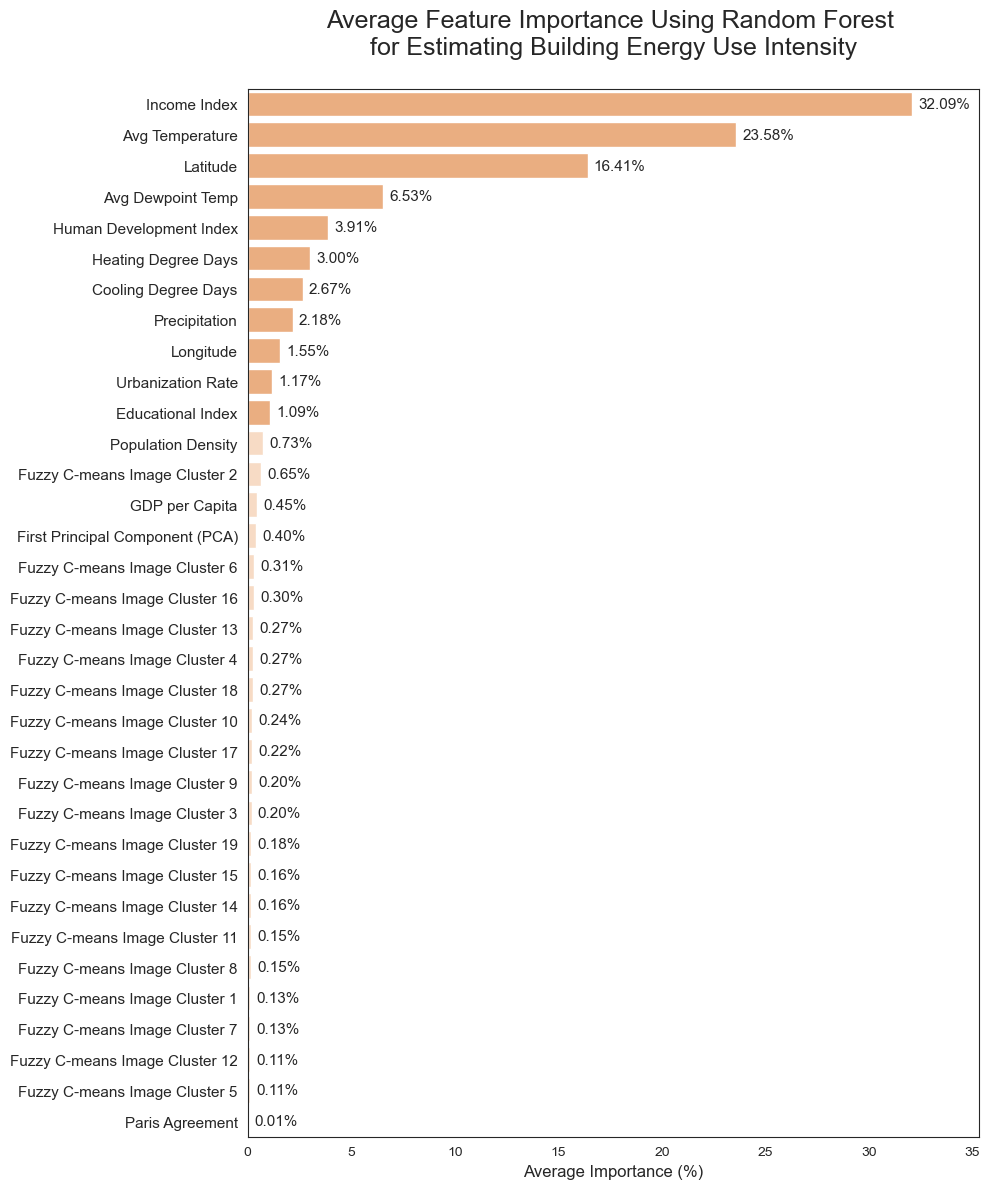

In [9]:
plt.figure(figsize=(10, 12))
sns.set_style("white")  

sorted_df = importance_df_abbr.sort_values(by='Average', ascending=False).copy()
sorted_df['Average'] *= 100

# Add a column for coloring
sorted_df['Above_Threshold'] = sorted_df['Average'] > 1

max_value = sorted_df['Average'].max()
x_limit = max_value * 1.1  

ax = sns.barplot(
    x='Average',
    y=sorted_df.index,
    hue='Above_Threshold',
    data=sorted_df,
    palette={True: '#fbab70', False: '#ffdabd'},
    errorbar=None,
    legend=False
)

plt.xlim(0, x_limit)
plt.yticks(fontsize=11)  

for i, v in enumerate(sorted_df['Average']):
    ax.text(v + 0.3, i, f'{v:.2f}%', va='center', fontsize=11)

plt.title('Average Feature Importance Using Random Forest \nfor Estimating Building Energy Use Intensity\n', fontsize=18)
plt.xlabel('Average Importance (%)', fontsize=12)
plt.ylabel('')   
plt.tight_layout()

save_path = '../figures/'
file_path = os.path.join(save_path, '05_feature_importance.png')
plt.savefig(file_path)

plt.show()